In [1]:
import nltk
nltk.download('punkt')
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
import re
import twikenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
#sns.set() #comment for heatmap
import demoji
import emoji
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram,average
from sklearn.decomposition import PCA
from sklearn.manifold import MDS,TSNE
from gensim.models import Word2Vec,FastText
import gensim.downloader
import pickle
import os
#demoji.download_codes()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anzea\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('dataset.csv')
df.describe()

,id,sentiment,target,text,source
count,97674,97674,15931,97662,97674
unique,64079,20,9,67936,7
top,3825,none,muslims,Almost all Muslims deliberately decide not to ...,kaggle-jigsaw
freq,22,33157,3864,37,41335


In [3]:
corpus = df[["text","sentiment"]]
corpus['text'] = corpus['text'].astype(str)
corpus['sentiment'] = corpus['sentiment'].astype(str)
corpus.applymap(str)
corpus.head()

<ipython-input-3-8396d5f7a9c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['text'] = corpus['text'].astype(str)
<ipython-input-3-8396d5f7a9c8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['sentiment'] = corpus['sentiment'].astype(str)


,text,sentiment
0,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,none
1,@politico No. We should remember very clearly ...,hateful
2,@cricketworldcup Guess who would be the winner...,none
3,Corbyn is too politically intellectual for #Bo...,none
4,All the best to #TeamIndia for another swimmin...,none


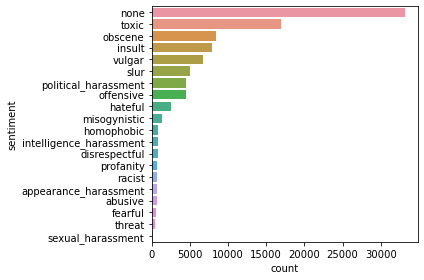

In [4]:
ax = sns.countplot(y='sentiment',data=corpus,order = corpus['sentiment'].value_counts().index)
plt.tight_layout()
plt.savefig('Count_labels.png')

In [5]:
def tokenize_and_stem_twk(text):
    twk = nltk.tokenize.TweetTokenizer()
    stemmer = SnowballStemmer("english")
    em = demoji.findall(text)
    for k,v in em.items():
        text = text.replace(k,v)
    # First tokenize by sentence, then by word to ensure that punctuation is caught as it's own token.
    tokens = [word for sent in nltk.sent_tokenize(text) for word in twk.tokenize(sent)]
    #tokens = [word for word in twk.tokenize(text)]
    
    filtered_tokens = []
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation).
    for token in tokens:
        if re.search('[a-zA-Z]', token) and not ("@" in token or "http" in token or "t.co" in token or "#" in token ): #or '\\u' in token
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens] # .replace('\\','')
    return stems

In [6]:
corpus_join_sentiment = corpus.groupby(['sentiment'])['text'].apply(lambda x: '. '.join(x)).reset_index()
corpus_join_sentiment

,sentiment,text
0,abusive,@user Still a bitter cunt. Why so much interes...
1,appearance_harassment,@lanablanco_bz @sabho_ you dat skank postn pi...
2,disrespectful,@user Sure except for directly quoting Trumps ...
3,fearful,If America had another 8 years of Obama's ideo...
4,hateful,@politico No. We should remember very clearly ...
5,homophobic,Hahaha grow up faggot @URL. Scomo the biggest ...
6,insult,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK. ...
7,intelligence_harassment,@_kashavels @javon_savage you2 r really ghetto...
8,misogynistic,Hahaha grow up faggot @URL. This bitch Is reta...
9,none,#DhoniKeepsTheGlove | WATCH: Sports Minister K...


In [7]:
save_file = 'tfidf_vectorizer_and_matrix.pickle'

if not os.path.isfile(save_file):
    # Define vectorizer parameters
    tfidf_vectorizer = TfidfVectorizer(
                            max_df=0.8, 
                            max_features=200000,
                            min_df=0.2, 
                            stop_words='english', 
                            use_idf=True, 
                            tokenizer=tokenize_and_stem_twk, 
                            ngram_range=(1,1))
    %time tfidf_matrix = tfidf_vectorizer.fit_transform(corpus_join_sentiment.text.to_list())
    print("TF-IDF matrix shape: {}".format(tfidf_matrix.shape))
    with open(save_file,'wb') as file:
        pickle.dump((tfidf_vectorizer,tfidf_matrix),file)
else:
    with open(save_file,'rb') as file:
        (tfidf_vectorizer,tfidf_matrix) = pickle.load(file)

Find TOP_N most important words for each Sentiment

In [8]:
TOP_N = 3
feature_names = tfidf_vectorizer.get_feature_names()
indices = np.argsort(tfidf_matrix.todense(),axis=1)
df_top_tfidf = pd.DataFrame(columns=['Sentiment','Top'])
for i in range(len(corpus_join_sentiment)):
    df_top_tfidf = df_top_tfidf.append({'Sentiment':corpus_join_sentiment.sentiment[i], 'Top': ', '.join([feature_names[indices[i,-j]] for j in range(1,TOP_N+1)])},ignore_index=True)

df_top_tfidf

,Sentiment,Top
0,abusive,"shithol, ching, chong"
1,appearance_harassment,"fatass, skank, rt"
2,disrespectful,"shithol, ching, chong"
3,fearful,"shithol, ching, chong"
4,hateful,"shithol, icc, chong"
5,homophobic,"dyke, game, nit"
6,insult,"wikipedia, jew, page"
7,intelligence_harassment,"fucktard, rt, shithead"
8,misogynistic,"feminazi, mongi, chong"
9,none,"articl, page, wikipedia"


Print TOP_N most important words with tf-ids score for each sentiment.

In [9]:
feature_names = tfidf_vectorizer.get_feature_names()
indices = np.argsort(tfidf_matrix.todense(),axis=1)
for i in range(len(corpus_join_sentiment)):
    print(corpus_join_sentiment.sentiment[i] )
    for j in range(1,10):
        print('\t',feature_names[indices[i,-j]],tfidf_matrix[i,indices[i,-j]])

abusive
	 shithol 0.43014062570607764
	 ching 0.4261915043251513
	 chong 0.41672058200681467
	 spic 0.25159168673374355
	 mongoloid 0.19766680995982527
	 negro 0.16216171206837585
	 mongi 0.14018435519592198
	 chinaman 0.10739834639839003
	 feminazi 0.09883340497991264
appearance_harassment
	 fatass 0.9496959708104242
	 skank 0.20311499439275255
	 rt 0.16552205367228473
	 toe 0.07567029202867251
	 camel 0.07567029202867251
	 fuckfac 0.027878528642142505
	 weight 0.027878528642142505
	 fug 0.027599251831805834
	 dickfac 0.02679516292729062
disrespectful
	 shithol 0.5429488302330444
	 ching 0.4107969426276701
	 chong 0.4038342825831333
	 spic 0.2326923558141619
	 mongoloid 0.16513304828987474
	 negro 0.16313644137599118
	 mongi 0.1499028060045605
	 dyke 0.11932941323803174
	 chinaman 0.10527354502311624
fearful
	 shithol 0.5069224788935331
	 ching 0.3647956955643848
	 chong 0.34507700931766133
	 spic 0.2872560713730021
	 mongi 0.1724669654925349
	 negro 0.15104256352816736
	 mongoloid 0.

In [10]:
def selecet_top_k_words(k,feature_names,tf_idf_matrix,sentiments):
    words = dict()
    indices = np.argsort(tf_idf_matrix.todense(),axis=1)
    for i,s in enumerate(sentiments):
        for j in range(1,k+1):
            _,l = words.setdefault(feature_names[indices[i,-j]],(indices[i,-j],set()))
            l.add(s)
    w,i = [],[]
    for k,(v,s) in words.items():
        w.append((k,s))
        i.append(v)
    return w,i

In [11]:
def selecet_top_k_words_label_with_top_score(k,feature_names,tf_idf_matrix,sentiments):
    words = dict()
    indices = np.argsort(tf_idf_matrix.todense(),axis=1)
    for i,s in enumerate(sentiments):
        for j in range(1,k+1):
            _,_,val = words.setdefault(feature_names[indices[i,-j]],(indices[i,-j],s,tf_idf_matrix[i,indices[i,-j]]))
            if val < tf_idf_matrix[i,indices[i,-j]]:
                words[feature_names[indices[i,-j]]]=(indices[i,-j],s,tf_idf_matrix[i,indices[i,-j]])
    w,i = [],[]
    for k,(v,s,_) in words.items():
        w.append((k,s))
        i.append(v)
    return w,i

Create heatmap of number of the same most importat words. Change variable `interested` to plot more than just interesant categories.

['abusive', 'misogynistic', 'disrespectful', 'fearful', 'hateful', 'homophobic', 'offensive', 'racist', 'intelligence_harassment', 'sexual_harassment', 'appearance_harassment', 'none', 'obscene', 'insult', 'toxic', 'threat', 'political_harassment', 'vulgar', 'slur', 'profanity']
(20, 20)


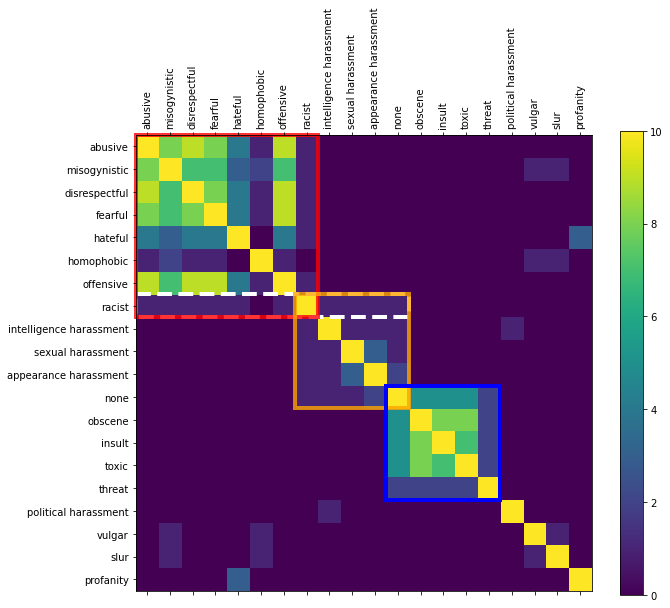

In [94]:
importat_words,importat_words_index = selecet_top_k_words(10,feature_names,tfidf_matrix,corpus_join_sentiment.sentiment)
word_matrix = tfidf_matrix[:, importat_words_index].T.todense()
interested = ['abusive', 'misogynistic', 'disrespectful', 'fearful', 'hateful', 'homophobic', 'offensive',  'racist', 'intelligence_harassment', 'sexual_harassment', 'appearance_harassment', 'none', 'obscene', 'insult','toxic', 'threat','political_harassment', 'vulgar', 'slur',  'profanity']#list(corpus_join_sentiment.sentiment)
print(interested)
#['abusive', "disrespectful", "fearful", "hateful", "misogynistic", "offensive"]#,'political_harassment','intelligence_harassment']
df_interested = corpus_join_sentiment.loc[corpus_join_sentiment['sentiment'].isin( interested)]
df_interested = df_interested.reset_index(drop=True)

#display(df_interested)
skupnih_besed = {ss : {s:0 for s in df_interested.sentiment}  for ss in df_interested.sentiment}
for s in df_interested.sentiment:
    for w,other_s in importat_words:
            if s in other_s:
                for ss in other_s:
                    #if s != ss:
                    if ss in interested:
                        skupnih_besed[s][ss] = skupnih_besed[s][ss]+1
                        
sentiment_to_index = {s:i for i,s in enumerate( interested)}
mat = np.zeros((len(interested),len(interested)))
print(mat.shape)
for k,v in skupnih_besed.items():
    for v1,c in v.items():
        mat[sentiment_to_index[k],sentiment_to_index[v1]] = c
#import matplotlib as mpl
#mpl.style.use('classic')
#print(mpl.style)
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.matshow(mat)
tic = np.arange(len(interested))
ax.set_xticks(tic)
ax.set_yticks(tic)
ax.set_xticklabels(labels=[s.replace('_', ' ') for s in interested],rotation=90)
ax.set_yticklabels(labels=[s.replace('_', ' ') for s in interested])
#ax.plot([-0.5,6.5,6.5,-0.5,-0.5],[-0.5,-0.5,6.5,6.5,-0.5],'red')
#ax.plot([6.5,9.5,9.5,6.5,6.5],[6.5,6.5,9.5,9.5,6.5],'green')
#ax.plot([8.5,12.5,12.5,8.5],[8.5,8.5],'orange')
import matplotlib.patches as patches
rect = patches.Rectangle((-0.5, -0.5), 8, 8, linewidth=4, edgecolor='red', facecolor='none',clip_on=False,alpha=0.8)

rect2 = patches.Rectangle((6.5, 6.5), 5, 5, linewidth=4, edgecolor='orange', facecolor='none',alpha=0.8)
rect3 = patches.Rectangle((10.5,10.5), 5, 5, linewidth=4, edgecolor='b', facecolor='none')

rect4 = patches.Rectangle((-0.5,6.5), 12, 1,linewidth=4, ls='--', edgecolor='white', facecolor='none',clip_on=False)

# Add the patch to the Axes

ax.add_patch(rect4)
ax.add_patch(rect)
ax.add_patch(rect2)
ax.add_patch(rect3)

fig.colorbar(im,shrink=0.75)
fig.tight_layout()
fig.savefig('heatmap_of_common_words.png')

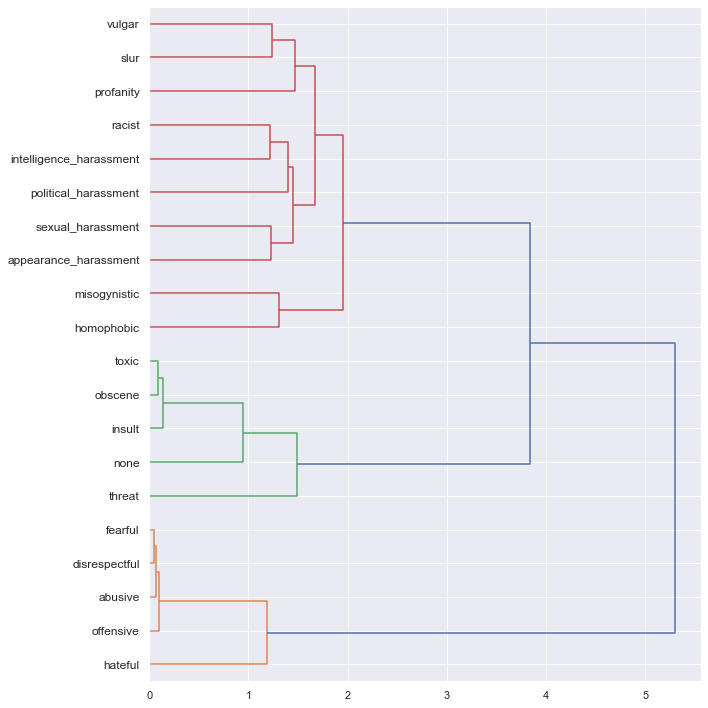

In [28]:
importat_words,importat_words_index = selecet_top_k_words(15,feature_names,tfidf_matrix,corpus_join_sentiment.sentiment)
word_matrix = tfidf_matrix[:, importat_words_index].T.todense()
dist = 1 - cosine_similarity(word_matrix.T)
linkage_matrix = ward(dist) 

fig, ax = plt.subplots(figsize=(10, 10)) # set size
ax = dendrogram(linkage_matrix, orientation="right",labels=corpus_join_sentiment.sentiment.to_list());
plt.tight_layout()
#plt.savefig('tf-idf_cluster.png')

In [30]:
#Can take some time.
if not os.path.isfile('stamed_corpus.pickle'):
    stamed_corpus = list(map(tokenize_and_stem_twk,corpus.text))
    with open('stamed_corpus.pickle','wb') as file:
        pickle.dump((tfidf_vectorizer,tfidf_matrix),file)
else:
    with open('stamed_corpus.pickle','rb') as file:
        stamed_corpus = pickle.load(file)

# Word2Vec

In [33]:
if not os.path.isfile('word2vec.model'):
    %time model_w2v = Word2Vec(stamed_corpus,min_count=1,size=64)
    model_w2v.save('word2vec.model')
#model_w2v = gensim.downloader.load('word2vec-google-news-300')
model_w2v = Word2Vec.load('word2vec.model')
word2vec_emb = np.array([model_w2v.wv[w]  for w,_ in importat_words])

# FastText

In [23]:
if not os.path.isfile('fasttext.model')
    model_ft = FastText(size=16,window=3,min_count=1)
    model_ft.build_vocab(stamed_corpus)
    model_ft.train(sentences=stamed_corpus,total_examples=len(stamed_corpus),epochs=10)
    model_ft.save('fasttext.model')
else:
    model_ft = FastText.load('fasttext.model')
fasttext_emb = np.array([model_ft.wv[w]  for w,_ in importat_words])


In [35]:
importat_words,importat_words_index = selecet_top_k_words_label_with_top_score(10,feature_names,tfidf_matrix,corpus_join_sentiment.sentiment)
embeddings =tfidf_matrix[:, importat_words_index].T.todense()

Select the emebeding to plot in the following cells. It is more readable.

In [36]:
#embeddings = fasttext_emb
#embeddings = word_matrix # tf-idf scores
embeddings = word2vec_emb

In [13]:
def mean_sent(importat_words,embeding,sentimens):
    s2pos = {s: [] for s in sentimens}
    for i,(w,ss) in enumerate(importat_words):
        for s in ss:
            s2pos[s].append(embeding[i,:])
    return {k:np.array(v).mean(axis=0) for k,v in s2pos.items()}
        

In [14]:
def mean_sent2(importat_words,embeding,sentimens):
    s2pos = {s: [] for s in sentimens}
    for i,(w,ss) in enumerate(importat_words):
            s2pos[ss].append(embeding[i,:])
    return {k:np.array(v).mean(axis=0) for k,v in s2pos.items()}
        

In [15]:
def plot_embed(words_with_sent,sentiment,embeding,save_path=None):
    fig, ax = plt.subplots(figsize=(15,15))
    xs, ys = pos[:, 0], pos[:, 1]
    ax.scatter(xs,ys)
    
    for (t,sents),x,y in zip(words_with_sent,xs,ys):
        ax.annotate(t,(x,y),alpha=0.8)
    for s ,c in mean_sent(words_with_sent,embeding,sentiment).items():
        ax.annotate(s, c,color='red',size=15)
    if save_path is not None:
        fig.tight_layout()
        fig.savefig(save_path)

In [16]:
def plot_embed2(words_with_sent,sentiment,embeding,save_path=None):
    df_plot = pd.DataFrame({'x':pos[:, 0],'y':pos[:, 1],'label':[ s.replace('_',' ') for w,s in words_with_sent]})
    fig, ax = plt.subplots(figsize=(15,15))
    xs, ys = pos[:, 0], pos[:, 1]
    #ax.scatter(xs,ys)
    ax = sns.scatterplot(data=df_plot,ax=ax,hue='label',x='x',y='y')
    for (t,sents),x,y in zip(words_with_sent,xs,ys):
        ax.annotate(t,(x,y),alpha=0.6)
    for s ,c in mean_sent2(words_with_sent,embeding,sentiment).items():
        if np.all(np.isfinite(c)):
            ax.annotate(s, c,color='red',size=15)
    if save_path is not None:
        fig.tight_layout()
        fig.savefig(save_path)

<ipython-input-14-515fa25b0073>:5: RuntimeWarning: Mean of empty slice.
  return {k:np.array(v).mean(axis=0) for k,v in s2pos.items()}
C:\Users\anzea\.conda\envs\nlp\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


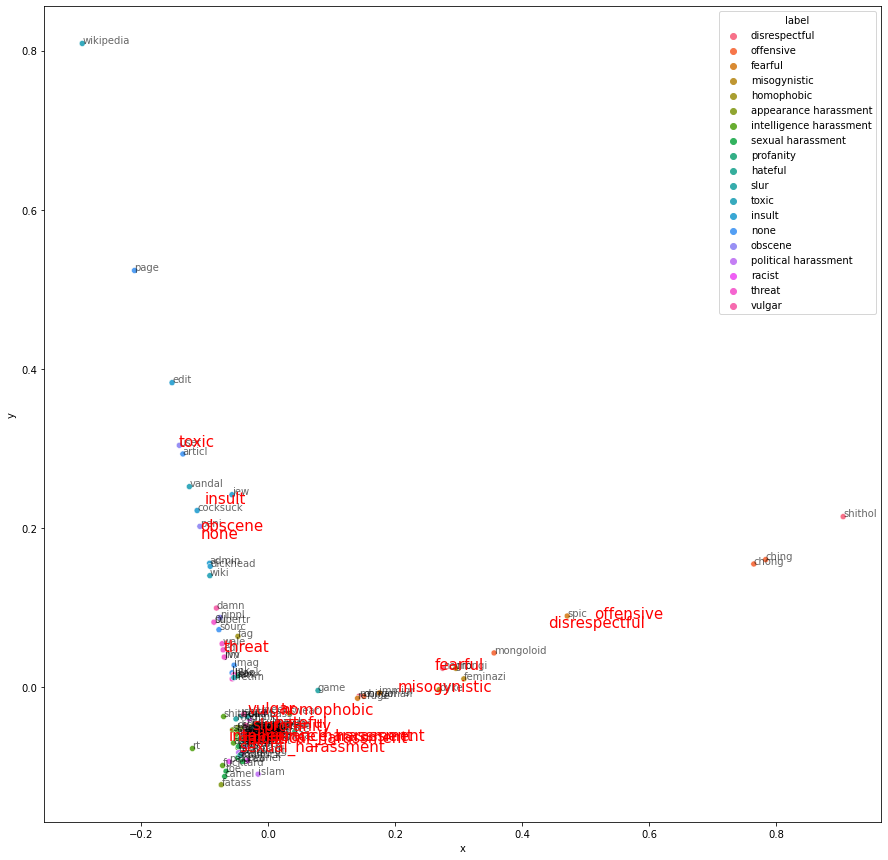

In [17]:
pca = PCA(n_components=2)
pos = pca.fit_transform(embeddings)

plot_embed2(importat_words,corpus_join_sentiment.sentiment,pos)


<ipython-input-14-515fa25b0073>:5: RuntimeWarning: Mean of empty slice.
  return {k:np.array(v).mean(axis=0) for k,v in s2pos.items()}
C:\Users\anzea\.conda\envs\nlp\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


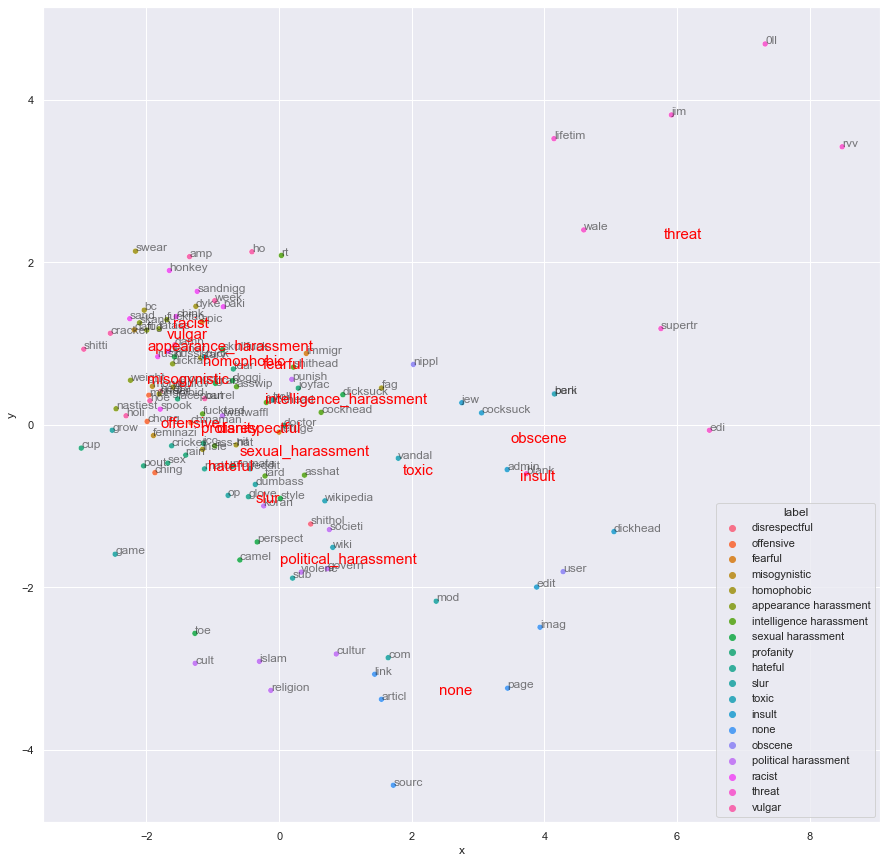

In [52]:

clf = LinearDiscriminantAnalysis(n_components=2)
y = LabelEncoder().fit_transform([s for w,s in importat_words])
pos = clf.fit_transform(embeddings, y)
plot_embed2(importat_words,corpus_join_sentiment.sentiment,pos,None)#'LDA-tfidf.png')#,'TSNE-tfidf.png'


C:\Users\anzea\.conda\envs\nlp\lib\site-packages\scipy\cluster\hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


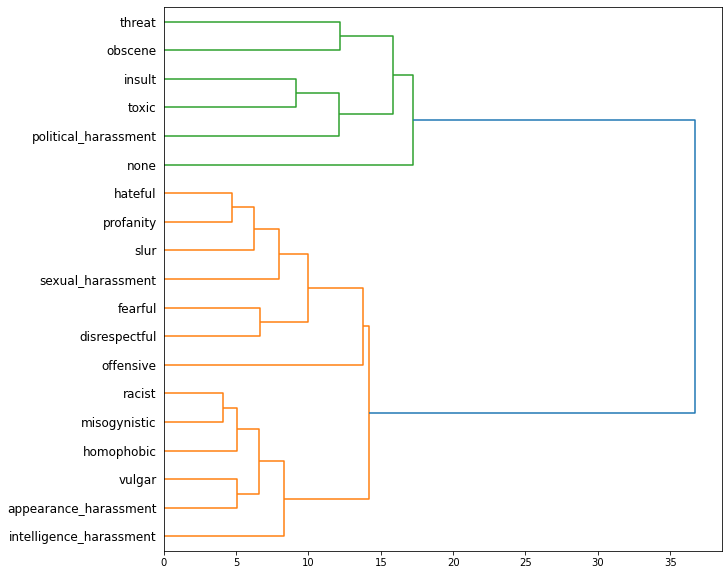

In [41]:
from scipy.spatial import distance_matrix
sent2vec = mean_sent2(importat_words,embeddings,[s for w,s in importat_words])
df_plot = pd.DataFrame(sent2vec).transpose()

dist = distance_matrix(df_plot.to_numpy(),df_plot.to_numpy())
# Define the linkage_matrix using ward clustering pre-computed distances.
linkage_matrix = ward(dist) 

fig, ax = plt.subplots(figsize=(10, 10)) # set size
ax = dendrogram(linkage_matrix, orientation="right",labels=df_plot.index);#,labels=corpus_join_sentiment.sentiment.to_list()

Wall time: 1.42 s


<ipython-input-47-515fa25b0073>:5: RuntimeWarning: Mean of empty slice.
  return {k:np.array(v).mean(axis=0) for k,v in s2pos.items()}
C:\Users\anzea\.conda\envs\nlp\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


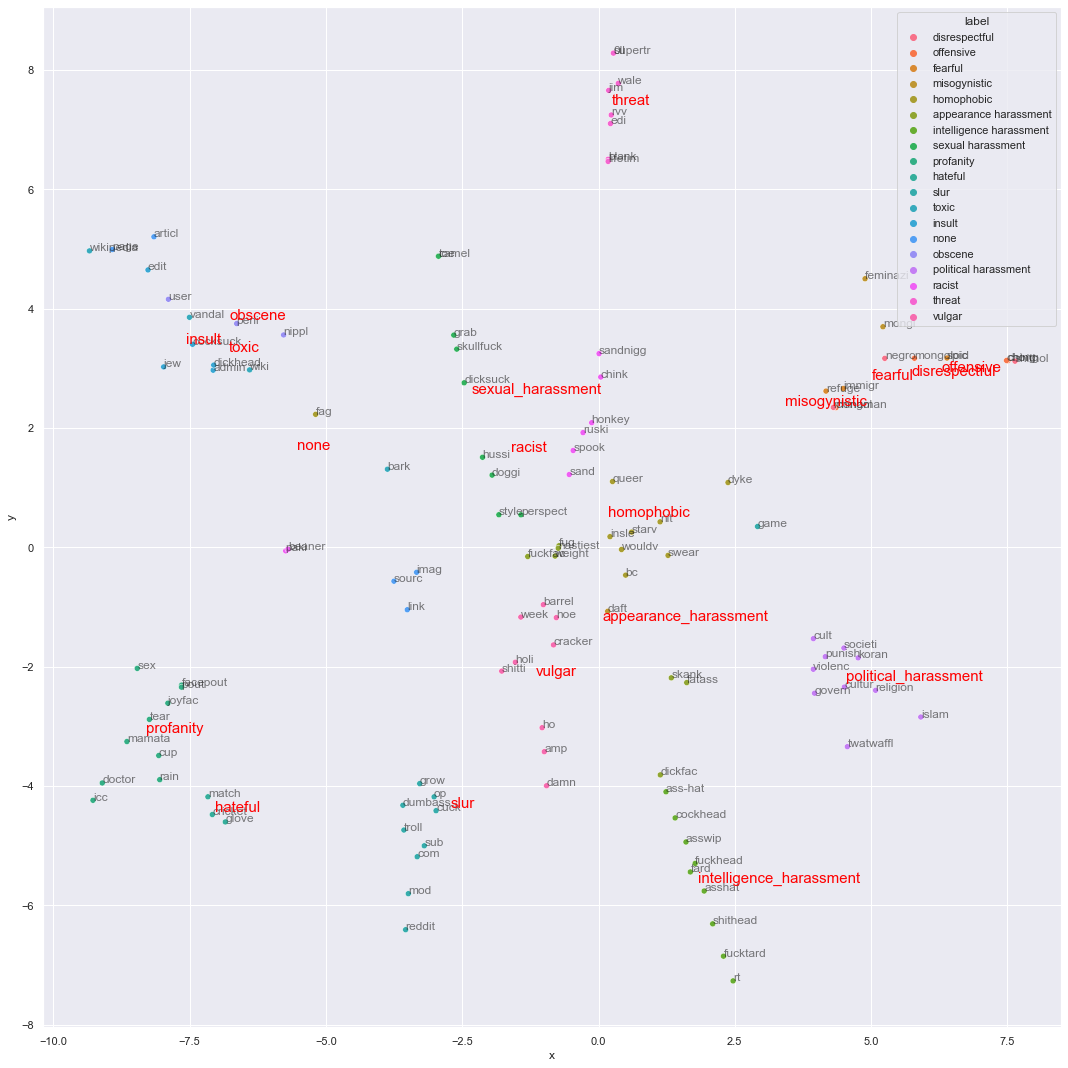

In [66]:
tsne = TSNE(n_components=2)#,perplexity=15
%time pos = tsne.fit_transform(embeddings)
plot_embed2(importat_words,corpus_join_sentiment.sentiment,pos,'TSNE-tfidf.png')#,'TSNE-tfidf.png'


Wall time: 419 ms


<ipython-input-47-515fa25b0073>:5: RuntimeWarning: Mean of empty slice.
  return {k:np.array(v).mean(axis=0) for k,v in s2pos.items()}
C:\Users\anzea\.conda\envs\nlp\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


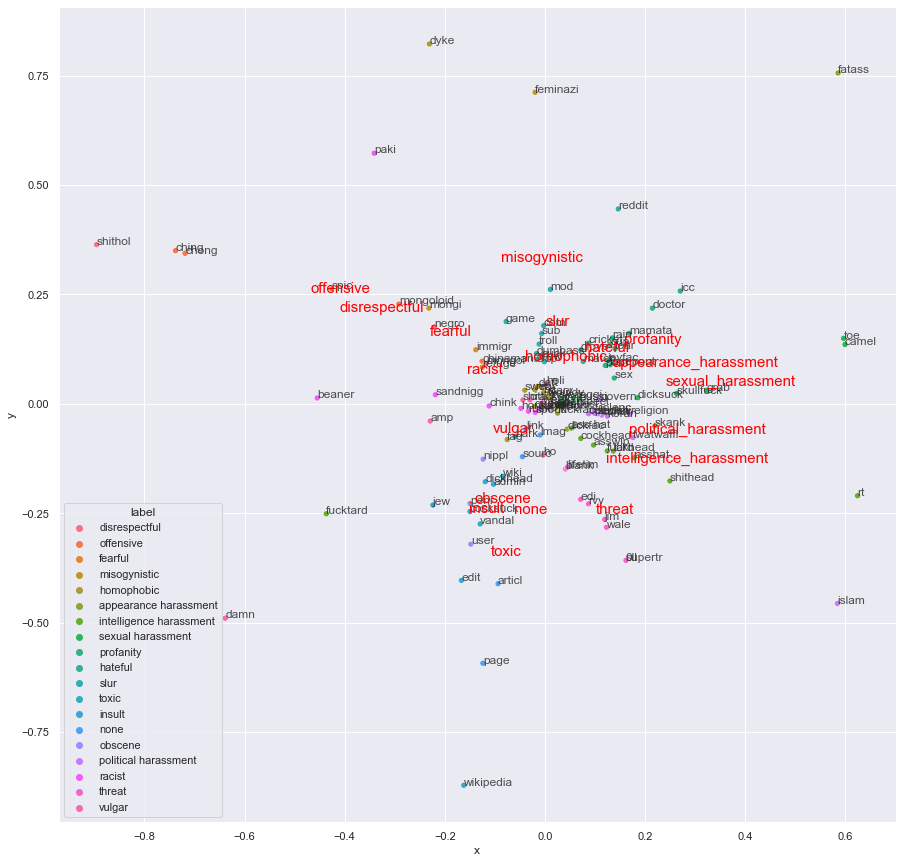

In [62]:
mds = MDS(n_components=2)
%time pos = mds.fit_transform(embeddings)
plot_embed2(importat_words,corpus_join_sentiment.sentiment,pos)